In [2]:
import numpy as np
import pandas as pd
from utils.data import load_tc_data
from utils.plot import make_cmap
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import seaborn as sns

# TODO: be sure about what's going on with inverted lats
# TODO: why are there blank images still?
# TODO: may need to look at generate_predictins_2 script to make sure the correct images are flipped

# If you have/make the file ~/.ssh/config, you can define settings to ssh from local to a BP node e.g.:
# Host bluepebble
# User yourusername
# Hostname bp1-login.acrc.bris.ac.uk
# PreferredAuthentications publickey
# ProxyCommand ssh yourusername@seis.bris.ac.uk nc %h %p

# Host bluepebble1
# User yourusername
# Hostname bp1-login01.acrc.bris.ac.uk
# PreferredAuthentications publickey
# ProxyCommand ssh yourusername@seis.bris.ac.uk nc %h %p
# Then start a notebook and make a local connection with something like:
# PORT=1234
# ssh -f -N -L 8080:localhost:$PORT bluepebble1
# ssh bluepebble1 "module load lang/python/anaconda; jupyter notebook --no-browser --port=$PORT"
# (choose a number that's likely to be unique to you for PORT. You can also insert a command to activate a given conda env after the model load part)

In [2]:
era5,era5_real,era5_input,era5_meta,mswep,mswep_real,mswep_input,mswep_meta = load_tc_data(set='extreme_valid',results='era5')

In [3]:
precip_cmap,precip_norm = make_cmap()

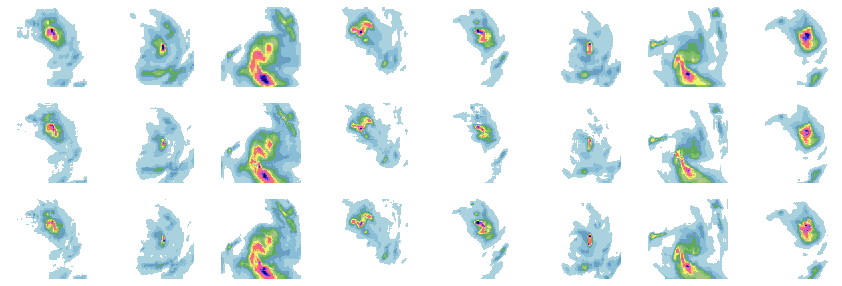

In [4]:
i = 100

gridspec = {'width_ratios': [1,1, 0.2]}
fig, axes = plt.subplots(3, 8, figsize=(15, 5))

storms = np.arange(0,200,10)
storm = 0
# for i in range(3):
for j in range(8):
	storm = storm + 1
	axes[0,j].axis('off')
	axes[1,j].axis('off')
	axes[2,j].axis('off')
	axes[0,j].imshow(mswep_input[storm],cmap=precip_cmap)
	axes[1,j].imshow(mswep[storm,:,:,0],cmap=precip_cmap)
	axes[2,j].imshow(mswep_real[storm],cmap=precip_cmap)


In [5]:
# plt.hist(era5_real.flatten(),bins=np.arange(0,55,0.5))
# sns.kdeplot(era5_real.flatten())
# # plt.show()
# sns.kdeplot(mswep_real.flatten())
# # plt.hist(mswep_real.flatten(),bins=np.arange(0,55,0.5))
# plt.show()


In [6]:
print(mswep_real.shape)
print(mswep.shape)
print(mswep_input.shape)
print(era5_real.shape)
print(era5.shape)
print(era5_input.shape)

(5425, 100, 100)
(5425, 100, 100, 20)
(5425, 40, 40)
(6553, 100, 100, 1)
(6553, 100, 100, 20)
(6553, 40, 40, 1)


In [7]:
def mean2d(array):
	return np.mean(np.mean(array,axis=1),axis=1)

mswep_real_2 = mean2d(mswep_real)
era5_real_2 = mean2d(era5_real)
mswep_2 = mean2d(mswep[:,:,:,0])
era5_2 = mean2d(era5[:,:,:,0])
mswep_input_2 = mean2d(mswep_input)
era5_input_2 = mean2d(era5_input[:,:,:,0])

In [8]:
print(era5_input_2)
print(era5_real_2)
print(era5_input[2021])

[0.         0.0013223  0.00199184 ... 0.00106843 0.00099354 0.0012774 ]
[[0.        ]
 [4.136875  ]
 [6.7664    ]
 ...
 [3.64905625]
 [3.53075625]
 [4.3076125 ]]
[[[1.21433288e-04]
  [1.87842175e-04]
  [2.75122002e-04]
  ...
  [5.88186085e-05]
  [3.26350331e-04]
  [7.03932717e-04]]

 [[2.58045271e-04]
  [2.77018175e-04]
  [2.53301114e-04]
  ...
  [1.38510019e-04]
  [2.69429758e-04]
  [6.06216490e-04]]

 [[3.76632437e-04]
  [4.03195620e-04]
  [3.73786315e-04]
  ...
  [1.21433288e-04]
  [2.27686018e-04]
  [2.46660784e-04]]

 ...

 [[0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  ...
  [9.48086381e-07]
  [0.00000000e+00]
  [0.00000000e+00]]

 [[0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  ...
  [3.13054770e-05]
  [2.75112689e-05]
  [1.51786953e-05]]

 [[0.00000000e+00]
  [0.00000000e+00]
  [1.89617276e-06]
  ...
  [1.11944973e-04]
  [1.31867826e-04]
  [1.19535252e-04]]]


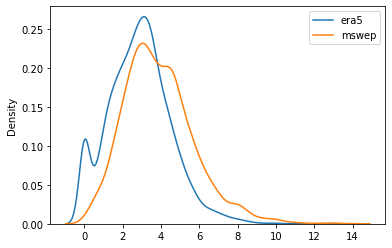

In [9]:
sns.kdeplot(era5_real_2.flatten())
sns.kdeplot(mswep_real_2.flatten())
plt.legend(['era5','mswep'])
plt.show()

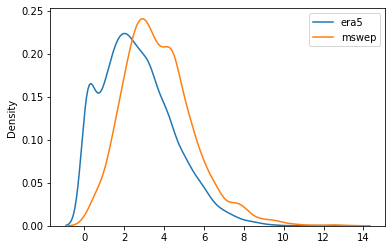

In [10]:
sns.kdeplot(era5_2.flatten())
sns.kdeplot(mswep_2.flatten())
plt.legend(['era5','mswep'])
plt.show()

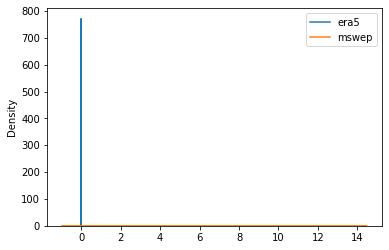

In [11]:
sns.kdeplot(era5_input_2.flatten())
sns.kdeplot(mswep_input_2.flatten())
plt.legend(['era5','mswep'])
plt.show()


In [4]:
data = np.load('/user/home/al18709/work/tc_data_era5_flipped/train_X.npy')
print(data.shape)

(56822, 40, 40)
